# Machine Learning Foundations


## Outline

1. Scenario:  linear regression on the Palmer Penguin dataset
    - Measures of a good regressor
2. Scenario:  classification on the Palmer Penguin dataset
    - Measures of a good classifier


## Datasets

- Palmer Penguins dataset - [credits](https://github.com/allisonhorst/palmerpenguins)


In [1]:
# import sys
# ! {sys.executable} -m pip install --user -r requirements.txt

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
import requests
import shutil
import math

# Import util, classifiers and performance metrics
from sklearn.utils import shuffle
from sklearn import svm, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from skimage import exposure

from utils import pad_image, download_file

# Plot inline in notebook
%matplotlib inline

# Make figures wider to see easier
plt.rcParams['figure.figsize'] = (16,3)
# Change axis area color to make it easier to see image area
plt.rcParams['figure.facecolor'] = 'grey'

## Scenario:  linear regression for predicting penguin bill depth 


### Get the data

In [3]:
PENGUIN_DATA_FILE = os.path.join('data', 'penguins.csv')

In [4]:
penguin_data = pd.read_csv(PENGUIN_DATA_FILE)

In [5]:
print('Shape of penguin dataset = ', penguin_data.shape)
penguin_data.head(10)

Shape of penguin dataset =  (344, 9)


,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
6,7,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female,2007
7,8,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male,2007
8,9,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,10,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007


### Exploratory data analysis


What species do we have in this dataset?

In [6]:
print(set(penguin_data['species']))

{'Gentoo', 'Chinstrap', 'Adelie'}


Print out the descriptive statistics for the whole penguin dataset.

In [7]:
penguin_data.describe(include='all')

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
count,344.000000,344,344,342.000000,342.000000,342.000000,342.000000,333,344.000000
unique,NaN,3,3,NaN,NaN,NaN,NaN,2,NaN
top,NaN,Adelie,Biscoe,NaN,NaN,NaN,NaN,male,NaN
freq,NaN,152,168,NaN,NaN,NaN,NaN,168,NaN
mean,172.500000,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN,2008.029070
std,99.448479,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN,0.818356
min,1.000000,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN,2007.000000
25%,86.750000,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN,2007.000000
50%,172.500000,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN,2008.000000
75%,258.250000,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN,2009.000000


Pick one species and select features

![](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/culmen_depth.png)

Artwork by @allison_horst

Select one species, `Gentoo` and features of interest.  The predictor will be `bill_length_mm` and the response variable will be `bill_depth_mm`.

In [8]:
gentoo_data = penguin_data[penguin_data['species'] == 'Gentoo']

# Select two quantitative features
gentoo_data = gentoo_data[['bill_length_mm', 'bill_depth_mm']]

print('Shape of Gentoo penguin dataset = ', gentoo_data.shape)
gentoo_data.head()

Shape of Gentoo penguin dataset =  (124, 2)


,bill_length_mm,bill_depth_mm
152,46.1,13.2
153,50.0,16.3
154,48.7,14.1
155,50.0,15.2
156,47.6,14.5


Plot our feature (bill length) against the response variable (bill depth).

Text(0, 0.5, 'Bill depth (mm)')

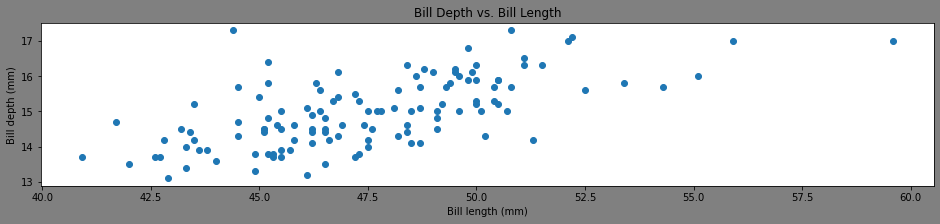

In [9]:
plt.scatter(x=gentoo_data['bill_length_mm'],
            y=gentoo_data['bill_depth_mm'])
plt.title('Bill Depth vs. Bill Length')
plt.xlabel('Bill length (mm)')
plt.ylabel('Bill depth (mm)')

### Clean the data

Not-a-number or NaN is generally needing to be dealt with before fitting a model.  Often it will be replaced with a number or just removed.  Here, we remove the NaNs from the smaller Gentoo penguin dataset.

In [10]:
# # what pandas method is needed here?  or you may create your own NaN remover.
gentoo_data.dropna(inplace=True)
gentoo_data.shape

(123, 2)

### Fit a linear regression model

We will regress Y (bill depth) onto X (bill length) or, in other words, use our quantitative variable X (bill length) to predict the quantitative response variable Y (bill depth).

In [11]:
# Create train and test datasets (reserving some data to test our model)
X = np.array(gentoo_data['bill_length_mm']).reshape(-1, 1)
Y = np.array(gentoo_data['bill_depth_mm']).reshape(-1, 1)

X, Y = shuffle(X, Y, random_state=0)

# Split data into 70% train and 30% test subsets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, shuffle=False)

# Train the model
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

### Predict

Coefficients:  [[0.20364959]]
Intercept:  [5.31196115]


Text(0, 0.5, 'Bill depth (mm)')

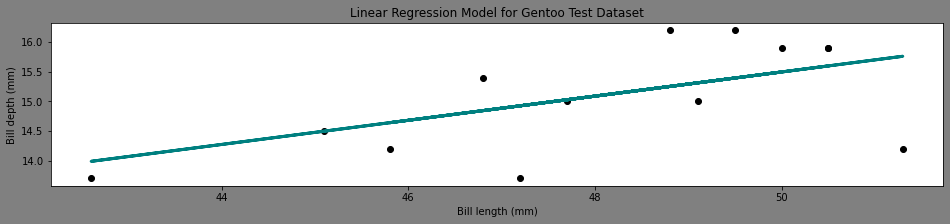

In [12]:
# Predict a response Y
Y_pred = reg.predict(X_test)

# The coefficients
print('Coefficients: ', reg.coef_)
print('Intercept: ', reg.intercept_)

# Plot outputs
plt.scatter(X_test, Y_test,  color='black')
plt.plot(X_test, Y_pred, color='teal', linewidth=3)

plt.title('Linear Regression Model for Gentoo Test Dataset')
plt.xlabel('Bill length (mm)')
plt.ylabel('Bill depth (mm)')

### Measures of a good regressor

In [13]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, Y_pred))

Mean squared error: 0.50
Coefficient of determination: 0.37


## Scenario:  Logistic regression for classification of Gentoo penguin species

![](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/lter_penguins.png)
Artwork by @allison_horst

Here we have a qualitative or categorical response variable, `species`.  We will use two species of the three above to create a binary classifier with logistic regression.  We will first take a look at what linear regression can do for us.

### Create the dataset

In [14]:
# Let's select our variables
species_data = penguin_data[['bill_depth_mm', 'species']]

# Let's limit to just 2 species as we want binary classifcation
species_data = species_data[species_data['species'] != 'Adelie']
species_data.dropna(inplace=True)

print('Shape of classification dataset = ', species_data.shape)

Shape of classification dataset =  (191, 2)


Most ML algorithms need all variables as numerical so even categorical variables must be numerical and we can do so by using "dummy variables" for those.

In [15]:
# Encode the response variable from string to numerical
species_encoded = [0 if x == 'Gentoo' else 1 for x in species_data['species']]
species_data['species'] = species_encoded

Chose our single variable, bill depth, and labels, the gender.


In [16]:
X = species_data[['bill_depth_mm']]
Y = species_data[['species']]

# Shuffle
X, Y = shuffle(X, Y, random_state=0)

# Split data into 70% train and 30% test subsets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

## What if we fit a linear regression model with our binary species dataset?

Coefficients:  [[0.20335422]]
Intercept:  [-2.93816216]
Mean squared error: 0.07
Coefficient of determination: 0.71


Text(0, 0.5, 'Species (0=Gentoo/1=Chinstrap)')

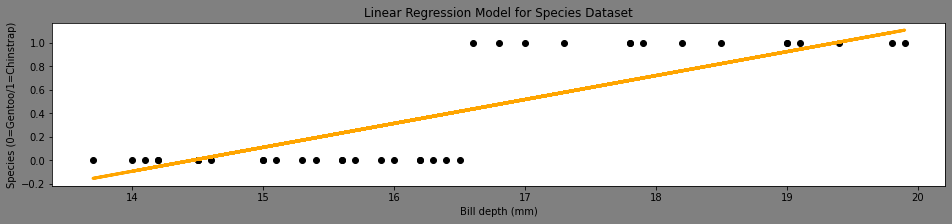

In [17]:
# Train a linear regression model
reg = LinearRegression()
reg.fit(X_train, Y_train)

# Predict a response Y
Y_pred = reg.predict(X_test)

# The coefficients
print('Coefficients: ', reg.coef_)
print('Intercept: ', reg.intercept_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, Y_pred))


# Plot outputs
plt.scatter(X_test, Y_test,  color='black')
plt.plot(X_test, Y_pred, color='orange', linewidth=3)

plt.title('Linear Regression Model for Species Dataset')
plt.xlabel('Bill depth (mm)')
plt.ylabel('Species (0=Gentoo/1=Chinstrap)')

What are the issues here?

### Fit a logistic regression model

In [18]:
# Initialize the classifier
clf = LogisticRegression(random_state=0)

# Learn the digits on the train subset
clf.fit(X_train, Y_train)

print('Classifier score = ', clf.score(X_test, Y_test))

### Predict

Classifier score =  0.9487179487179487


Text(0, 0.5, 'Species (0=Gentoo/1=Chinstrap)')

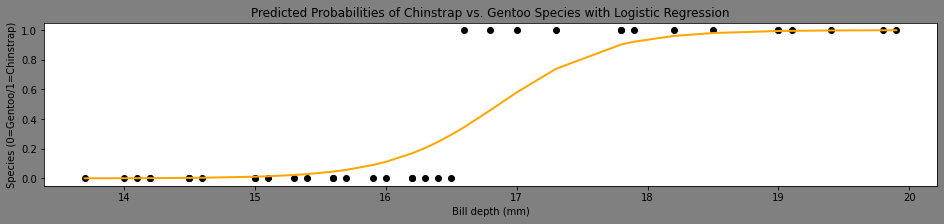

In [18]:
# Prediction
Y_pred = clf.predict(X_test)

# Probabilities (female or male)
probas = clf.predict_proba(X_test)

# Get probability male (second column of probabilities)
prob_male = probas[:, 1].reshape(1,-1)[0]

# Plot outputs
plt.scatter(X_test, Y_test,  color='black')

# To plot the probabilities correctly must sort X's
X_test_sorted, prob_male_reordered = zip(*sorted(zip(X_test['bill_depth_mm'], 
                                                     prob_male),key=lambda x: x[0]))
plt.plot(X_test_sorted, prob_male_reordered, color='orange', linewidth=2)

plt.title('Predicted Probabilities of Chinstrap vs. Gentoo Species with Logistic Regression')
plt.xlabel('Bill depth (mm)')
plt.ylabel('Species (0=Gentoo/1=Chinstrap)')

### Challenge:  Writing a sigmoid or logistic function on toy data
Do you recall from our lecture what the logistic function was?  It is a type of signmoidal curve.  Fill in the blanks below to draw the sigmoid curve on the toy data.

Hint:  `numpy` makes it easy to use `e` or Euler's number to an exponent given as the values in `x`.

In [19]:
# x = np.linspace(-10, 10, 100)
# z = ___ / ___

# plt.plot(x, z)
# plt.xlabel("x")
# plt.ylabel("Sigmoid(X)")

# plt.show()

### Measures of a good classifier

Confusion matrix

Confusion matrix:
[[24  0]
 [ 2 13]]



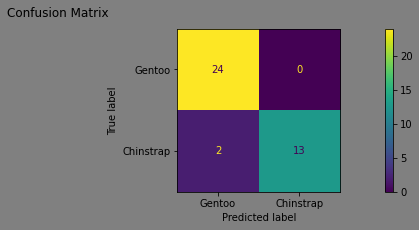

In [20]:
disp = metrics.plot_confusion_matrix(clf, X_test, Y_test, 
                                     display_labels=['Gentoo','Chinstrap'])
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
print('')
plt.show()

Do you see any issues with this classification experiment?

In [21]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(Y_test, Y_pred)}\n")

Classification report for classifier LogisticRegression(random_state=0):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.87      0.93        15

    accuracy                           0.95        39
   macro avg       0.96      0.93      0.94        39
weighted avg       0.95      0.95      0.95        39




### Challenge

Replace LogisticRegression with a different off-the-shelf classifier (like a support vector machine or k-nearest neighbor algorithm) in the code cell above that defines and uses the classifier and try another classification experiment.

- [SVM](https://scikit-learn.org/stable/modules/svm.html) - hint:  you may wish to try different kernels
- [KNN](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) - remember the curse of dimensionality
- ...